<a href="https://colab.research.google.com/github/kay-squared/PyTorchLearn/blob/main/02_PyTorch_NN_classification_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network classification with PyTorch
Resources:

https://www.learnpytorch.io/02_pytorch_classification/

https://github.com/mrdbourke/pytorch-deep-learning/blob/main/02_pytorch_classification.ipynb

Questions in https://github.com/mrdbourke/pytorch-deep-learning/discussions

## 1. Prepare a toy classification data set for binary classification

Scikitlearn has a lot of tool to generate ttoy datasets:

https://scikit-learn.org/stable/datasets/toy_dataset.html

In [1]:
import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np


### 1.0 Create data

In [2]:
# make 1000 samples
n_samples=1000
# create circles
X,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

print(len(X), len(y))
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")


1000 1000
First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [3]:
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "y": y})
circles.head()

,X1,X2,y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


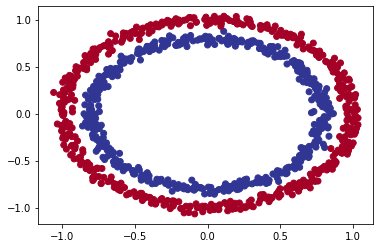

In [4]:
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Check input and output shapes

In [5]:

X_sample= X[0]
y_sample=y[0]
print(f"Values for one sample of X: {X_sample} and y: {y_sample}")
print(f"Shapes of data: X: {X.shape} and y: {y.shape}")


Values for one sample of X: [0.75424625 0.23148074] and y: 1
Shapes of data: X: (1000, 2) and y: (1000,)


### 1.2 Turn data into tensors and create train and test splits

In [6]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
print(X[:3],y[:3])
print(type(X),X.dtype,y.dtype)

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733]]) tensor([1., 1., 1.])
<class 'torch.Tensor'> torch.float32 torch.float32


In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(f"Size of traininig set: X: {X_train.shape} and y: {y_train.shape}")
print(f"Size of test set: X: {X_test.shape} and y: {y_test.shape}")


Size of traininig set: X: torch.Size([800, 2]) and y: torch.Size([800])
Size of test set: X: torch.Size([200, 2]) and y: torch.Size([200])


## 2. Building a model

1. Set up device agnostic code
2. Construct a model by subclassing nn.Module
3. Define a loss function and optimizer
4. Create an train and test loop

### 2.1 Device agnostic code

later: send model and data to device

In [8]:

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### 2.1.1 Construct a Model

1. Subclass nn.Module 
2. Create 2 linear layers that are capable of handlnig the shapes of our data)
3. define a forward pass
4. Instantiate and send to target devcie

Check our http://playground.tensorflow.org/ for different architectures

In [9]:
# 1. subclassing
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    #2. Create 2 layers
    self.layer_1 = nn.Linear(in_features=2,
                             out_features=5)
    self.layer_2 = nn.Linear(in_features=5,
                             out_features=1)
    
    #self.two_linear_layers= nn.Sequential(
    #    nn.Linear(in_features=2,out_features=5),
    #    nn.Linear(in_features=5,out_features=1)
    #)
    
    # 3. forward pass
    def forward(self,x):
      return self.layer_2(self_layer_1(x))
      #return self.two_linear_layers(x)

# 4. instatiate and send to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [10]:
next(model_0.parameters()).device

device(type='cuda', index=0)

### 2.1.2 Constructing the model another way

This is simpler, but for more complicated NN, the first way will prevail

In [11]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
)
model_0 = model_0.to(device)

In [12]:
model_0.state_dict()


OrderedDict([('0.weight', tensor([[ 0.7009,  0.0396],
                      [-0.3265,  0.1224],
                      [-0.0435, -0.5599],
                      [ 0.3916,  0.5233],
                      [-0.6443,  0.1830]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.2868,  0.6183, -0.2747,  0.2510, -0.0864], device='cuda:0')),
             ('1.weight',
              tensor([[-0.0789,  0.3395,  0.1722,  0.3031, -0.0575]], device='cuda:0')),
             ('1.bias', tensor([-0.0710], device='cuda:0'))])

### The result of this model 
is, at the moment, still a real number, not a category: check that out

In [13]:
# check out predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
  print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
  print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
  print(f"\n First 10 predictions: \n {untrained_preds[:10]}")
  print(f"\n First 10 labels: \n {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

 First 10 predictions: 
 tensor([[0.2182],
        [0.2362],
        [0.1342],
        [0.2421],
        [0.0757],
        [0.0871],
        [0.1841],
        [0.1491],
        [0.1368],
        [0.2367]], device='cuda:0')

 First 10 labels: 
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.2 Cost function and optimizer

* As a loss function, use binary cross entropy or categorical cross entropy For reading up on binary cross entropy check out https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a by Daniel Godoy.  Note. that usinig BCEWithLogit implement the sigmoidal activation function, so you dont have to impelement it expliicitely in the last layer, whereas BCELoss does not - and requires explicit implementation. THe BCEWithLogit uses some trick and is numerically more stable!
* As an optimizer, use Adam() or SGD(). (see torch.optim)



In [14]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

### Create a evaluation metric:

* $ACC = frac{TP+TN}{TP+TN+FP+FN}

In [15]:
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))
  return acc



## 3. Train model

1. Forward pass
2. Loss
3. zero_grad
4. backpropagation (loss.backward())
5. gradient descent (optimizer.step())



### 3.1 Logit --> prediction probabiliity --> prediction labels

** This is needed for the prediction of accuracy! **

The raw outputs of the model will be **logits** that have to be converted into **prediction probabilities** by passing then through an activation function (eg sigmoid for binary classification and softmax for multiclass classification)

Then the prodiction probabilities can vbe turned intp **prediction lables** by rounding or by taking the argmax()

For the predicted labels, we need to perform a range-sttyle rounding on them:
* y_pred_probs>=0.5 --> y=1
* y_pred_probs<0.5 --> y=0


In [16]:
model_0.eval()
# check it out
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))
  y_logits[:5]
  y_pred_probs = torch.sigmoid(y_logits)
  #print(y_pred_probs[:5])
  #print(torch.round(y_pred_probs[:5]))

# this is how it is done
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device)))).squeeze()
print(y_pred_labels[:5])
print(y_test[:5].to(device))


tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([1., 0., 1., 0., 1.], device='cuda:0')


In [17]:
 
 torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
 

Epoch: 0 | Loss: 0.69589, Accuracy: 0.50% | Test loss: 0.69798, Test acc: 0.50%
Epoch: 10 | Loss: 0.69417, Accuracy: 0.50% | Test loss: 0.69600, Test acc: 0.50%
Epoch: 20 | Loss: 0.69350, Accuracy: 0.59% | Test loss: 0.69516, Test acc: 0.57%
Epoch: 30 | Loss: 0.69322, Accuracy: 0.54% | Test loss: 0.69480, Test acc: 0.51%
Epoch: 40 | Loss: 0.69310, Accuracy: 0.53% | Test loss: 0.69464, Test acc: 0.50%
Epoch: 50 | Loss: 0.69305, Accuracy: 0.52% | Test loss: 0.69457, Test acc: 0.49%
Epoch: 60 | Loss: 0.69303, Accuracy: 0.52% | Test loss: 0.69455, Test acc: 0.49%
Epoch: 70 | Loss: 0.69301, Accuracy: 0.52% | Test loss: 0.69455, Test acc: 0.48%
Epoch: 80 | Loss: 0.69300, Accuracy: 0.51% | Test loss: 0.69456, Test acc: 0.47%
Epoch: 90 | Loss: 0.69300, Accuracy: 0.52% | Test loss: 0.69457, Test acc: 0.47%


In [20]:
import requests
from pathlib import Path
# Download helper functions from Learn PyTorch rep
if Path('helper_functions.py').is_file():
  print('helper_function.py already exists, skipping download')
else:
  print('Downloading helper_functions.py')
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")   # must be raw file
  with open('helper_functions.py','wb') as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary



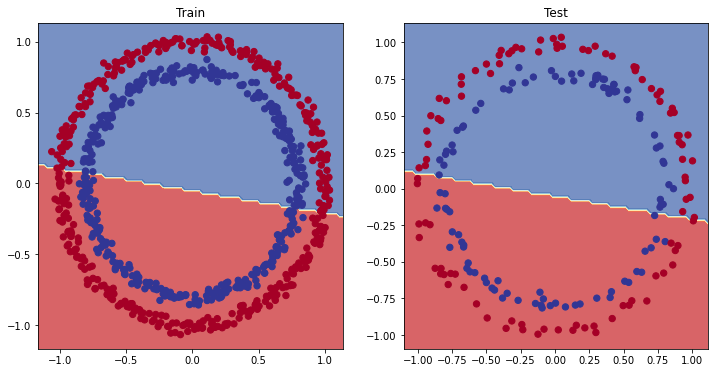

In [21]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# Clearly, this model is too simple to represent the data well!

In [18]:
# 1. subclassing
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    #2. Create 2 layers
    self.layer_1 = nn.Linear(in_features=2,
                             out_features=10)
    self.layer_2 = nn.Linear(in_features=10,
                             out_features=10)
    self.layer_3 = nn.Linear(in_features=10,
                             out_features=1)
    
    #self.two_linear_layers= nn.Sequential(
    #    nn.Linear(in_features=2,out_features=5),
    #    nn.Linear(in_features=5,out_features=1)
    #)
    
    # 3. forward pass
    def forward(self,x):
      return self.layer_3(self.layer_2(self_layer_1(x)))
      #return self.two_linear_layers(x)

# 4. instatiate and send to target device
model_1 = CircleModelV0().to(device)
model_1

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_1